In [1]:
import os
import json
import glob
import json
import pandas as pd
import numpy as np

In [4]:
def parse_result(path):
    line_list = open(path,'r').readlines()
    lines = [line.strip() for line in line_list]
    end_line = lines[-1].split(', ')
    best_eer = end_line[-1].split(' ')[-1]
    result = {}
    sum_minDCF = 0
    for i,line in enumerate(lines):
        try:
            cur_eer = line.split(', ')[-2].split(' ')[-1]
            cur_best_eer = line.split(', ')[-1].split(' ')[-1]
            if cur_eer == cur_best_eer == best_eer:
                for j in range(i-2,i):
                    splits = lines[j].split(', ')
                    gender = splits[0].split(' ')[-1]
                    eer = splits[1].split(' ')[-1]
                    minDCF = splits[2].split(' ')[-1]
                    result[gender] = {'eer': float(eer.split('%')[0]), 'minDCF': float(minDCF)}
                    sum_minDCF += float(minDCF)
        except :
            pass
    result['overall'] = {'eer': float(best_eer.split('%')[0]), 'minDCF': sum_minDCF/2}
    return result


In [139]:
LOOP = 5

In [4]:
for l in range(LOOP):
    files = glob.glob('./checkpoints_combine/exp3/loop%s/*/score-stage.txt'%(l+1))
    for file in files:
        result = parse_result(file)
        index = file.rfind('/')
        path = file[:index]
        name = 'dev_results.json'
        with open(os.path.join(path, name), 'w') as f:
            json.dump(result,f)

In [161]:
def concate_result(files, loop, store=False):
    data = {
        'phase': [],
        'eer': [],
        'gender': [],
        'minDCF': [],
        'text': [],
        'loop': [],
        'word': []
        }
    parse = files[0].split('/')
    path = '/'.join(parse[:-2])
    for file in files:
        res = json.load(open(file, 'r'))
        splits = file.split('/')
        if 'eval' in splits[-1]:
            phase = 'eval'
        if 'dev' in splits[-1]:
            phase = 'dev'
        if 'all' in splits[-1]:
            phase ='eval'
        text = splits[-2]
        word = text.split('_')[0]
        
        for g in res:
            data['gender'].append(g)
            data['eer'].append(res[g]['eer'])
            data['minDCF'].append(res[g]['minDCF'])
            data['phase'].append(phase)
            data['text'].append(text)
            data['loop'].append(loop)
            data['word'].append(word)
    df = pd.DataFrame(data)
    if store:
        save_path = os.path.join(path, 'all_eval_result_new_data.csv')
        print('Save result to %s' % (save_path))
        df.to_csv(save_path, index=False)
    return df

In [168]:
for l in range(1,LOOP,1):
    result_files = glob.glob('pretrained_checkpoints/exp3/loop%s/*/all_eval_results_new_data.json'%(l+1))
    df = concate_result(result_files,l+1,store=True)

Save result to pretrained_checkpoints/exp3/loop2/all_eval_result_new_data.csv
Save result to pretrained_checkpoints/exp3/loop3/all_eval_result_new_data.csv
Save result to pretrained_checkpoints/exp3/loop4/all_eval_result_new_data.csv
Save result to pretrained_checkpoints/exp3/loop5/all_eval_result_new_data.csv


In [167]:
result_files = glob.glob('experiment_checkpoints/exp2/*/all_eval_results.json')
df = concate_result(result_files,2,store=True)

Save result to experiment_checkpoints/exp2/all_eval_result_new_data.csv


In [9]:
def plot_result(df_all, gender, phase, loop):
    import matplotlib.pyplot as plt
    result = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender)].sort_values('word')
    # print(result) 
    text = [str(x) for x in range(0,10)]
    plt.figure(figsize=(12,6))
    plt.suptitle('%s - Iteration %s' % (gender, loop))

    plt.subplot(1,2,1)
    plt.bar(text, result['minDCF'],0.4, label='minDCF')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('minDCF')
    
    plt.subplot(1,2,2)
    plt.bar(text, result['eer'],0.4, label='EER')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('EER (%)')
    plt.show()
    

In [169]:
def get_result(data,max_loop=3):
    result = {
    }
    genders = ['female', 'male', 'all']
    phases = ['eval']
    words = [x for x in range(0,10)]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result

                

    

In [30]:
json.dump(result, open('experiment_checkpoints/result_eval_average.json', 'w'))

In [183]:
df_all = pd.DataFrame()
MAX_LOOP = 5
for loop in range(2,MAX_LOOP+1):
    df_all = pd.concat([df_all, pd.read_csv('pretrained_checkpoints/exp3/loop%s/all_eval_result_new_data.csv'%(loop))], ignore_index=True)
result = get_result(df_all, max_loop=5)

In [184]:
df_all

,phase,eer,gender,minDCF,text,loop,word
0,eval,2.775510,female,0.170620,9_9,2,9
1,eval,2.244898,male,0.186021,9_9,2,9
2,eval,2.504000,all,0.193045,9_9,2,9
3,eval,0.846667,female,0.047370,6_6,2,6
4,eval,2.333333,male,0.163960,6_6,2,6
...,...,...,...,...,...,...,...
115,eval,0.448980,male,0.023983,0_0_0_0_0,5,0
116,eval,0.412000,all,0.019785,0_0_0_0_0,5,0
117,eval,0.100000,female,0.005569,9_9_9_9_9,5,9
118,eval,0.320000,male,0.020504,9_9_9_9_9,5,9


In [185]:
json.dump(result, open('pretrained_checkpoints/result_stage2_exp3_eval_new_data.json', 'w'))

In [186]:
import matplotlib.pyplot as plt

In [194]:
def show_result(result, metric='eer',all=False, start_loop=1, end_loop=5):
    if all:
        genders = ['overall']
    else:
        genders =  ['female','male','all']
    for gender in genders:
        plt.figure(figsize=(12,4))
        name_set = list(result.keys())
        a = []
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        for v in result['eval'][gender][metric].values():
            a.extend(v)
        min_ = min(a)
        max_ = max(a)
        for idx,set in enumerate(name_set):
            plt.subplot(1,len(name_set),idx+1)
            set_result = result[set]
            for i in range(0,10):
                plt.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
            plt.legend([i for i in range(0,10)])
            plt.xticks([ i for i in range(start_loop,end_loop+2)])
            plt.xlabel('Loop')
            plt.ylim((min_-1,max_+1))
            plt.ylabel(metric)
            plt.title(gender)
        # plt.savefig('results/output_exp1_%s.png'%(gender))

In [189]:
result = {}
result['1'] = json.load(open('pretrained_checkpoints/result_stage2_exp1_eval_new_data.json','r'))
result['2'] = json.load(open('pretrained_checkpoints/result_stage2_exp2_eval_new_data.json','r'))
result['3'] = json.load(open('pretrained_checkpoints/result_stage2_exp3_eval_new_data.json','r'))


In [190]:
MAX_LOOP = 5
phases = ['eval']
metrics = ['eer', 'minDCF']
genders = ['female', 'male', 'all']
final_result = {}
for phase in phases:
    final_result[phase] = {}
    for gender in genders:
        final_result[phase][gender] = {}
        for metric in metrics:
            final_result[phase][gender][metric] = {}
            for i in range(0,10):
                temp = []
                for exp in result:
                    temp.append(result[exp][phase][gender][metric][str(i)][:MAX_LOOP])
                value = np.mean(temp, axis=0)
                final_result[phase][gender][metric][i] = value





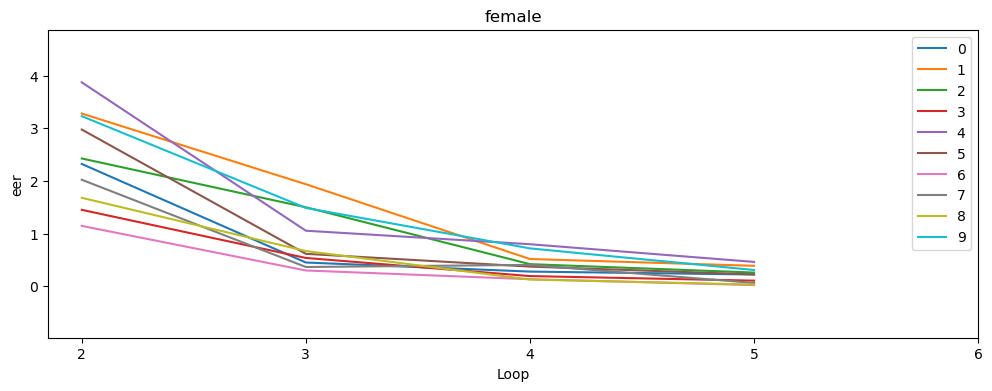

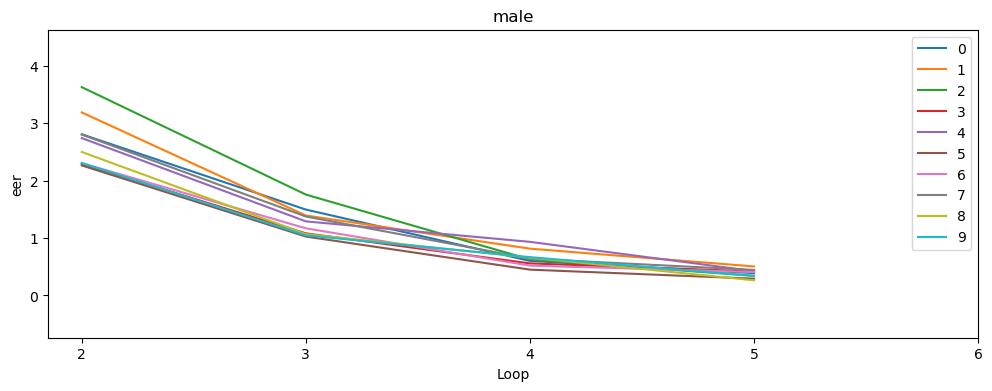

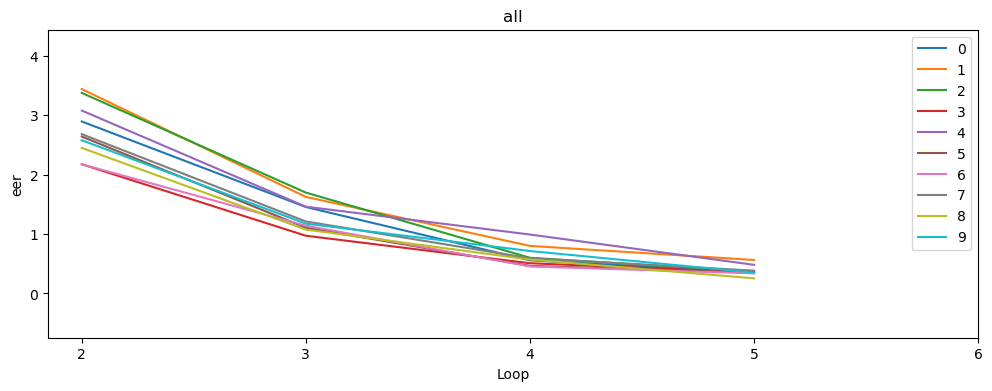

In [195]:
show_result(final_result,metric='eer',all=False, start_loop=2,end_loop=5)

# Compare 6-6 to other

In [ ]:
df_all = pd.DataFrame()
files = glob.glob('experiment_checkpoints/*/all_eval_result.csv')
for file in files:
    df_all = pd.concat([df_all, pd.read_csv(file)], ignore_index=True)
result = {
    }
genders = ['female', 'male', 'all']
phases = ['eval']
words = [(1, 3), (1, 6), (1, 9), (3, 1), (3, 6), (3, 9), (6, 1), (6, 3), (6, 9), (9, 1), (9, 3), (9, 6)]
for phase in phases:
    result[phase] = {}
    for gender in genders:
        result[phase][gender] = {
            'eer': {},
            'minDCF': {},
        }
        for word in words:
            text = [str(w) for w in word]
            text = '_'.join(text)
            df = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender) & (df_all['text']==text)]
            # print(data['word'])
            result[phase][gender]['eer'][text] = np.mean(df['eer'].to_list())
            result[phase][gender]['minDCF'][text] = np.mean(df['minDCF'].to_list())


In [64]:

array = []
for i in range(0,10):
    temp = []
    for gender in ['female','male','all']:
        temp.append(final_result['eval'][gender]['eer'][i][0])
    array.append(temp)
avg = np.mean(array,axis=1)
avg # 1 3 6 9

array([7.63404308, 6.8581746 , 7.86173243, 6.43727589, 7.95888209,
       7.30177627, 6.80984127, 7.02786546, 7.38183673, 6.39103477])

In [98]:
keys = ['1', '3', '6', '9']
filter = {}
for gender in ['female', 'male', 'all']:
    filter[gender] = {} 
    filter[gender]['eer'] = {}
    filter[gender]['minDCF'] = {}
    for digit in keys:
        filter[gender]['eer'][digit + '_' + digit] = final_result['eval'][gender]['eer'][int(digit)][1]
        filter[gender]['minDCF'][digit +  '_' + digit] = final_result['eval'][gender]['minDCF'][int(digit)][1]

In [99]:
result['eval']

{'female': {'eer': {'1_3': 10.228662131519274,
   '1_6': 12.760408163265305,
   '1_9': 10.771292517006804,
   '3_1': 9.964444444444446,
   '3_6': 9.519138321995463,
   '3_9': 10.226666666666667,
   '6_1': 11.615374149659866,
   '6_3': 8.494331065759637,
   '6_9': 11.456825396825394,
   '9_1': 10.844852607709752,
   '9_3': 10.849886621315193,
   '9_6': 11.708888888888888},
  'minDCF': {'1_3': 0.8583986394557822,
   '1_6': 0.8589950113378689,
   '1_9': 0.8733968253968255,
   '3_1': 0.8689972789115649,
   '3_6': 0.7963251700680273,
   '3_9': 0.8824793650793651,
   '6_1': 0.844550566893424,
   '6_3': 0.7325573696145122,
   '6_9': 0.8631999999999999,
   '9_1': 0.8913764172335599,
   '9_3': 0.8719895691609976,
   '9_6': 0.8561709750566897}},
 'male': {'eer': {'1_3': 11.114716553287982,
   '1_6': 10.294138321995463,
   '1_9': 10.500850340136052,
   '3_1': 11.140804988662131,
   '3_6': 10.38285714285714,
   '3_9': 11.698639455782311,
   '6_1': 10.621303854875285,
   '6_3': 10.644104308390022,


In [100]:
filter

{'female': {'eer': {'1_1': 8.110884353741497,
   '3_3': 6.5191836734693895,
   '6_6': 5.73968253968254,
   '9_9': 7.90748299319728},
  'minDCF': {'1_1': 0.47392244897959196,
   '3_3': 0.34824625850340146,
   '6_6': 0.3079160997732422,
   '9_9': 0.4540512471655331}},
 'male': {'eer': {'1_1': 8.369444444444445,
   '3_3': 6.902120181405895,
   '6_6': 6.068888888888888,
   '9_9': 6.22611111111111},
  'minDCF': {'1_1': 0.4758307256235819,
   '3_3': 0.3826243764172339,
   '6_6': 0.40547471655328765,
   '9_9': 0.4234730158730156}},
 'all': {'eer': {'1_1': 8.556562358276643,
   '3_3': 6.771083900226756,
   '6_6': 6.054222222222222,
   '9_9': 6.7851156462585065},
  'minDCF': {'1_1': 0.5018474376417235,
   '3_3': 0.38115619047619087,
   '6_6': 0.3812984126984131,
   '9_9': 0.45125895691609985}}}

In [101]:
for gender in ['female', 'male', 'all']:
    filter[gender]['eer'].update(result['eval'][gender]['eer'])
    filter[gender]['minDCF'].update(result['eval'][gender]['minDCF'])
    

In [102]:
filter

{'female': {'eer': {'1_1': 8.110884353741497,
   '3_3': 6.5191836734693895,
   '6_6': 5.73968253968254,
   '9_9': 7.90748299319728,
   '1_3': 10.228662131519274,
   '1_6': 12.760408163265305,
   '1_9': 10.771292517006804,
   '3_1': 9.964444444444446,
   '3_6': 9.519138321995463,
   '3_9': 10.226666666666667,
   '6_1': 11.615374149659866,
   '6_3': 8.494331065759637,
   '6_9': 11.456825396825394,
   '9_1': 10.844852607709752,
   '9_3': 10.849886621315193,
   '9_6': 11.708888888888888},
  'minDCF': {'1_1': 0.47392244897959196,
   '3_3': 0.34824625850340146,
   '6_6': 0.3079160997732422,
   '9_9': 0.4540512471655331,
   '1_3': 0.8583986394557822,
   '1_6': 0.8589950113378689,
   '1_9': 0.8733968253968255,
   '3_1': 0.8689972789115649,
   '3_6': 0.7963251700680273,
   '3_9': 0.8824793650793651,
   '6_1': 0.844550566893424,
   '6_3': 0.7325573696145122,
   '6_9': 0.8631999999999999,
   '9_1': 0.8913764172335599,
   '9_3': 0.8719895691609976,
   '9_6': 0.8561709750566897}},
 'male': {'eer': 

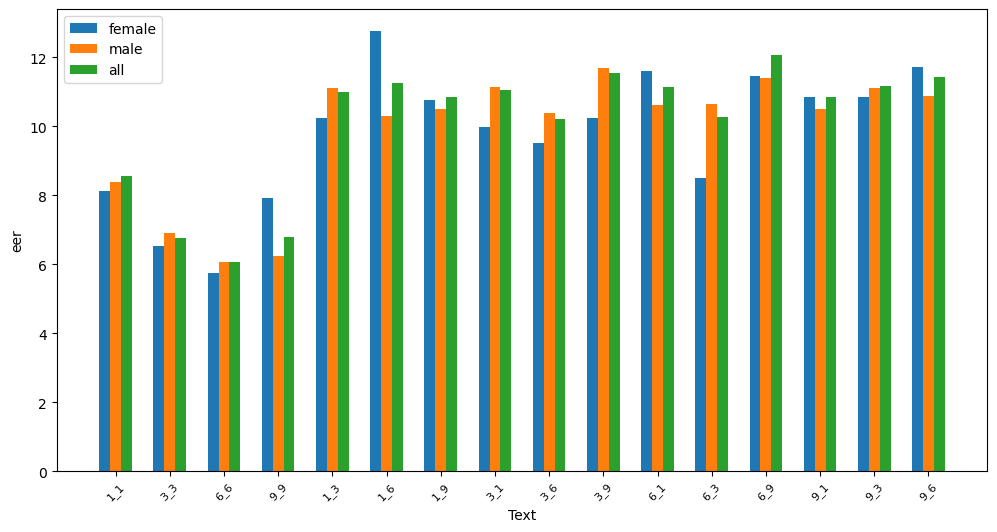

In [138]:
param = [-0.2, 0, +0.2]
plt.figure(figsize=(12,6))
# data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
plt.bar(np.arange(len(filter['female']['eer'])) - 0.2, list(filter['female']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['male']['eer'])), list(filter['male']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['all']['eer']))  +0.2, list(filter['all']['eer'].values()),width=0.2)
plt.xlabel('Text')
plt.ylabel(metric)
plt.legend(['female', 'male', 'all'])
plt.xticks(ticks=range(len(filter['female']['eer'])),labels=filter['female']['eer'].keys(),fontsize=8, rotation=45)
plt.show()
        # plt.savefig('experiment_checkpoints/%s.png' % (gender))